#### Link to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

#### Import datasets

In [14]:
# Set path
path = "/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/"

# Load your dataset
df_higgs = pd.read_csv(path + "higgs_train.csv")
higgs_test = pd.read_csv(path + "higgs_test.csv")  # adjust path as necessary
test_submission = pd.read_csv(path + "higgs_test_submission.csv")  # adjust path as necessary

# Replace values in 'Label' column
df_higgs['Label'] = df_higgs['Label'].replace({'b': 0, 's': 1})

# Separate features and target variable in training data
X_train = df_higgs.drop('Label', axis=1)
y_train = df_higgs['Label']

In [15]:
training_data = df_higgs
test_data = higgs_test

#### Generate Screeplots and run PCA

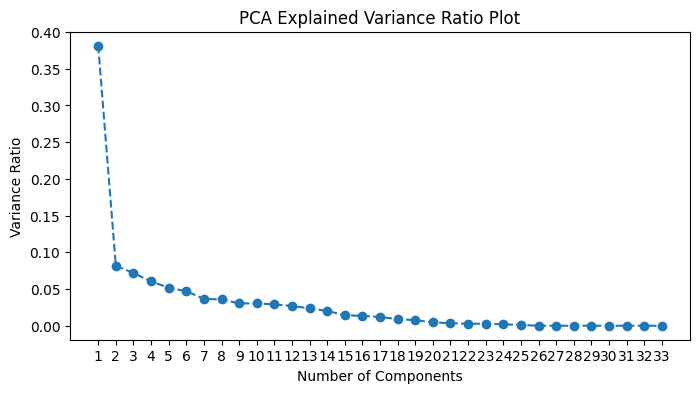

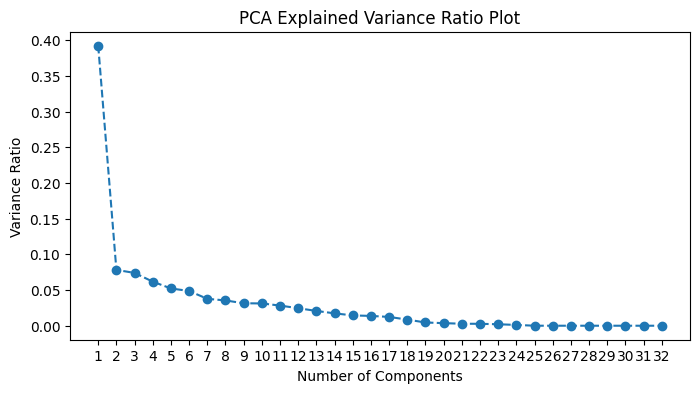

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define the function for screeplot and PCA
def perform_pca_and_plot(data):
    # Standardizing the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Performing PCA without reducing dimensionality to retain all components
    pca = PCA()
    pca.fit(data_scaled)

    # Calculating the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plotting the Scree Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
    plt.title('PCA Explained Variance Ratio Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.show()

# Call the function on training and test data
perform_pca_and_plot(training_data)
perform_pca_and_plot(test_data)

#### Run PCA and check variance based on n-components

In [18]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the function to perform PCA
def perform_pca(data, n_components=10):
    # Standardizing the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Performing PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)

    # Creating a DataFrame with principal components
    column_names = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(data=principal_components, columns=column_names)

    # Examining the explained variance
    explained_variance = pca.explained_variance_ratio_
    total_explained_variance = explained_variance.sum()  # Summing the explained variance

    print("Explained Variance per Component: ", explained_variance)
    print("Total Explained Variance: ", total_explained_variance)
    print(pca_df.head())

    return pca_df

# Call the function and store the results
training_data_PCA = perform_pca(training_data, n_components=10)
test_data_PCA = perform_pca(test_data, n_components=10)

Explained Variance per Component:  [0.38142627 0.0817787  0.07171555 0.06049967 0.05164791 0.04706814
 0.03659071 0.03574767 0.03051753 0.03029443]
Total Explained Variance:  0.8272865888757397
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.096399 -0.104970 -0.644941  0.515990  1.764536 -0.645774 -0.754430   
1 -3.523387  1.033225 -0.453494 -0.828091 -0.528431  1.268745 -1.216337   
2 -3.647076  1.474702 -0.416170 -0.549667  0.297747  0.371424 -1.351317   
3  3.973756 -1.158452 -2.274934 -0.318829  0.181242 -1.276843 -0.823183   
4 -3.617488  2.133874 -0.319017  2.180860  0.086350 -0.588637  1.760608   

        PC8       PC9      PC10  
0 -0.519652 -1.129348  0.825606  
1  0.799722  1.021450  1.022456  
2  0.188908 -0.209996  1.616358  
3 -0.368960  0.257590  0.183686  
4 -0.305073  0.270954 -0.595511  
Explained Variance per Component:  [0.39244722 0.0782669  0.07398774 0.06176167 0.05221225 0.04869605
 0.03769706 0.03544529 0.03146333 0.03124117]
Tot

*Neural* Network on PCA data and no Kfoldcross validation

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Assuming 'training_data_PCA' is your PCA-transformed training dataset and 'label_train' are the corresponding labels
# 'test_data_PCA' is your PCA-transformed test dataset without labels

# Convert features and labels to PyTorch tensors for training data
X_train = torch.tensor(training_data.drop('Label', axis=1).values, dtype=torch.float32)
Y_train = torch.tensor(training_data['Label'].values, dtype=torch.float32)
X_test = torch.tensor(test_data_PCA.values, dtype=torch.float32)  # Test data


# Define a neural network model
class HiggsClassifier(nn.Module):
    def __init__(self, input_size):
        super(HiggsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Create an instance of the model
input_size = X_train.shape[1]
model = HiggsClassifier(input_size)

# Define a loss function and an optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Print the training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item()}')

# Making predictions on test data
model.eval()
test_predictions = []
with torch.no_grad():
    for inputs in DataLoader(X_test, batch_size=64):
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        test_predictions.extend(predicted.numpy())

# Convert to DataFrame and save to CSV
test_predictions_df = pd.DataFrame(test_predictions, columns=['Predictions'])
test_predictions_df.to_csv('test_data_results_noPCA&Kfold.csv', index=False)

print(f'Test data predictions saved to test_data_results.csv')


Epoch [1/10] Loss: 54.16666793823242
Epoch [2/10] Loss: 66.66666412353516
Epoch [3/10] Loss: 54.16666793823242
Epoch [4/10] Loss: 58.33333206176758
Epoch [5/10] Loss: 58.33333206176758
Epoch [6/10] Loss: 58.33333206176758
Epoch [7/10] Loss: 58.33333206176758
Epoch [8/10] Loss: 37.5
Epoch [9/10] Loss: 62.5
Epoch [10/10] Loss: 83.33333587646484


RuntimeError: ignored